In [1]:
# Import necessary libraries
import torch
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import PIL

In [2]:
def read_img(path='./data/dog.png'):
    # Read a PIL image
    image = Image.open(path).convert('RGB')
    
    # Define a transform to convert PIL 
    # image to a Torch tensor
    transform = transforms.Compose([
        transforms.PILToTensor()
    ])
    
    # transform = transforms.PILToTensor()
    # Convert the PIL image to Torch tensor
    img_tensor = transform(image)/255
    # print(img_tensor)
    # img_tensor = img_tensor[0:3, :, :]
    # print the converted Torch tensor
    # print(img_tensor)
    print("processed image shape:", img_tensor.size())
    print("original image:")
    plt.imshow(image)
    plt.show()
    return img_tensor

processed image shape: torch.Size([3, 284, 401])
original image:


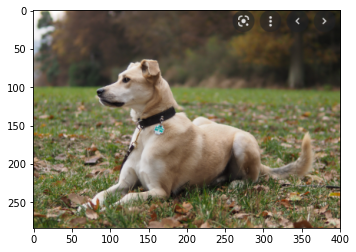

In [3]:
img_tensor = read_img()

added perturbations:


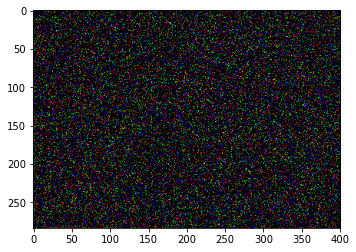

In [4]:
class AddGaussianNoise(object):
    def __init__(self, image, noise_scale):
        self.image_tensor = image
        self.noise_scale = noise_scale

    def __call__(self):
        n_scale = int(5 - self.noise_scale)
        modification_part_shape = (3, int(self.image_tensor.size()[1]/n_scale), int(self.image_tensor.size()[2]/n_scale))

        rand_additive = torch.randn(modification_part_shape)
        # rand_additive = torch.tensor(rand_additive, dtype=torch.int8)
        # print("rand_additive:", rand_additive.size())
        rand_additive = rand_additive.flatten()
        remained_size = 3*self.image_tensor.size()[1]*self.image_tensor.size()[2] - rand_additive.size()[0]
        rest = torch.zeros((remained_size))
        # rest = torch.tensor(rest, dtype=torch.int8)
        perturb = torch.cat((rand_additive, rest))
        perturb_idx = torch.randperm(perturb.size(0))
        perturb = perturb[perturb_idx]
        perturb = perturb.reshape(3, self.image_tensor.size()[1], self.image_tensor.size()[2])
        perturb = torch.clamp(perturb, min=0, max=1)

        # print("perturb", perturb)
        # rand_additive = torch.trunc(rand_additive)
        transformed = self.image_tensor +  perturb             # torch.ones(self.image_tensor.size())
        transformed = torch.clamp(transformed, min=0, max=1)
        # print("transformed", transformed)
        print("added perturbations:")
        to_pil = transforms.ToPILImage()
        img = to_pil(perturb)
        plt.imshow(img)
        plt.show()
        return transformed

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

transformed = AddGaussianNoise(image=img_tensor, noise_scale=3)
transformed = transformed()

after the perturbation:


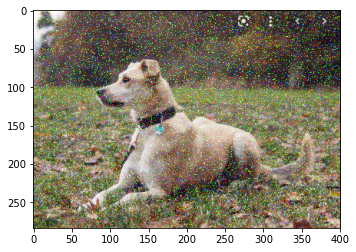

In [5]:
to_pil = transforms.ToPILImage()
img = to_pil(transformed)
print("after the perturbation:")
plt.imshow(img)
plt.show()

added perturbations:


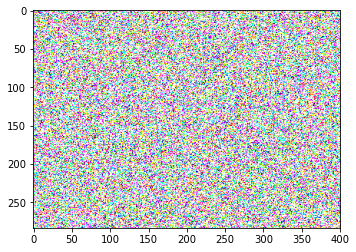

after the perturbation:


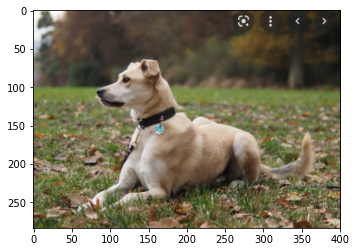

In [6]:
class AddGaussianNoise(object):
    def __init__(self, image, noise_scale):
        self.image_tensor = image
        self.noise_scale = noise_scale

    def __call__(self):
        n_scale = int(5 - self.noise_scale)
        modification_part_shape = (3, int(self.image_tensor.size()[1]/n_scale), int(self.image_tensor.size()[2]/n_scale))

        rand_additive = torch.zeros(modification_part_shape)
        # rand_additive = torch.tensor(rand_additive, dtype=torch.int8)
        # print("rand_additive:", rand_additive.size())
        rand_additive = rand_additive.flatten()
        remained_size = 3*self.image_tensor.size()[1]*self.image_tensor.size()[2] - rand_additive.size()[0]
        rest = torch.ones((remained_size))
        # rest = torch.tensor(rest, dtype=torch.int8)
        perturb = torch.cat((rand_additive, rest))
        perturb_idx = torch.randperm(perturb.size(0))
        perturb = perturb[perturb_idx]
        perturb = perturb.reshape(3, self.image_tensor.size()[1], self.image_tensor.size()[2])
        # perturb = torch.clamp(perturb, min=0, max=1)

        # print("perturb", perturb)
        # rand_additive = torch.trunc(rand_additive)
        transformed = self.image_tensor +  perturb             # torch.ones(self.image_tensor.size())
        # transformed = torch.clamp(transformed, min=0, max=1)
        # print("transformed", transformed)
        print("added perturbations:")
        to_pil = transforms.ToPILImage()
        img = to_pil(perturb)
        plt.imshow(img)
        plt.show()
        return transformed

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

transformed = AddGaussianNoise(image=img_tensor, noise_scale=3)
transformed = transformed()

to_pil = transforms.ToPILImage()
img = to_pil(transformed)
print("after the perturbation:")
plt.imshow(img)
plt.show()

In [7]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Gradient_Net(nn.Module):

  def __init__(self):

    super(Gradient_Net, self).__init__()
    kernel_x = [[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]]
    kernel_x = torch.FloatTensor(kernel_x).unsqueeze(0).unsqueeze(0).to(device)
    kernel_y = [[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]]
    kernel_y = torch.FloatTensor(kernel_y).unsqueeze(0).unsqueeze(0).to(device)
    self.weight_x = nn.Parameter(data=kernel_x, requires_grad=False)
    self.weight_y = nn.Parameter(data=kernel_y, requires_grad=False)

  def forward(self, x):
    grad_x = F.conv2d(x, self.weight_x)
    grad_y = F.conv2d(x, self.weight_y)
    gradient = torch.abs(grad_x) + torch.abs(grad_y)
    return gradient

In [8]:
scale_factor = 0.07

In [ ]:
grad = Gradient_Net()
image2 = Image.open('./data/dog.png').convert('L')
image3 = Image.open('./data/dog.png').convert('RGB')
plt.imshow(image3)
plt.show()

transform = transforms.Compose([
        transforms.PILToTensor()
    ])
img_tensor = transform(image2)/255
print(img_tensor.size())
img_tensor = img_tensor.reshape(1, 1, 284, 282)
gradient = grad.forward(img_tensor)
print(gradient.size())
gradient = gradient.reshape(1, 282, 280)*scale_factor # + torch.randn((1, 282, 280))

to_pil = transforms.ToPILImage()
img = to_pil(gradient).convert('RGB')
# img = to_pil(gradient).convert('L')
# img = to_pil(gradient).convert('LA')
print("gradient:")
plt.imshow(img)
plt.show()



In [ ]:
perturb_img_tensor = transform(img)/255
print(perturb_img_tensor.size())
perturb_img_tensor = F.pad(perturb_img_tensor, (1, 1, 1, 1))
print(perturb_img_tensor.size())
original_img_tensor = read_img()
print(original_img_tensor.size())

In [ ]:
transformed = original_img_tensor +  perturb_img_tensor
img = to_pil(transformed).convert('LA')
print("after perturb")
plt.imshow(img)
plt.show()